## Rough Bergomi: Implied Vol Surface
Visualize the implied vol surface for the rBergomi model implemented in `src.model.rbergomi`

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pyarrow as pa
from datetime import datetime

from src.model.rbergomi import rBergomiMCModel
from qablet_contracts.timetable import py_to_ts, TS_EVENT_SCHEMA
from qablet.base.flags import Stats
from src.utils import find_vol

### Parameters

In [ ]:
PATHS = 100_000
TIMESTEP = 1 / 250

prc_dt = datetime(2013, 8, 14)

ticker = "SPX"
rate = 0.0
spot = 1
div_rate = 0.00  # should be .02

H = 0.05
v0 = 0.025
eta = 2.3
rho = -0.9

Assemble Parameters into [dataset format](https://qablet-academy.github.io/intro/dataset/) for qablet models.

In [ ]:
times = np.array([0.0, 5.0])
rates = np.array([rate, rate])
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

dataset = {
    "BASE": "USD",
    "PRICING_TS": py_to_ts(prc_dt).value,
    "ASSETS": {"USD": discount_data, "SPX": fwd_data},
    "MC": {
        "PATHS": PATHS,
        "TIMESTEP": TIMESTEP,
        "SEED": 1,
        "FLAGS": Stats.CASHFLOW,
    },
    "rB": {"ASSET": "SPX", "ALPHA": H - 0.5, "RHO": rho, "XI": v0, "ETA": eta},
}

### Contract
In order to recostruct the volsurface we will define a contract which is a series of forwards paying at different option expiration dates. Then we will use the cashflow stats to get the values at all paths, from which we can reconstrcut option prices for different strikes and maturities.

In [ ]:
# We will define a forwards for various expirations
expirations = [
    # datetime(2013, 8, 16),  # in two days
    datetime(2013, 8, 23),  # weekly
    datetime(2013, 8, 30),  # weekly
    datetime(2013, 9, 20),  # monthly
    datetime(2013, 12, 20),  # quarterly
    datetime(2014, 3, 21),  # quarterly
    datetime(2014, 6, 20),  # quarterly
]
events = [
    {
        "track": "",
        "time": dt,
        "op": "+",
        "quantity": 1,
        "unit": ticker,
    }
    for dt in expirations
]

events_table = pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA)
fwd_timetable = {"events": events_table, "expressions": {}}
print(fwd_timetable["events"].to_pandas())

  track                      time op  quantity unit
0       2013-08-23 00:00:00+00:00  +       1.0  SPX
1       2013-08-30 00:00:00+00:00  +       1.0  SPX
2       2013-09-20 00:00:00+00:00  +       1.0  SPX
3       2013-12-20 00:00:00+00:00  +       1.0  SPX
4       2014-03-21 00:00:00+00:00  +       1.0  SPX
5       2014-06-20 00:00:00+00:00  +       1.0  SPX


Get price and stats. We are mainly interested in stats

In [ ]:
model = rBergomiMCModel()
price, stats = model.price(fwd_timetable, dataset)
# cashflows for track 0, all events
cf = stats["CASHFLOW"][0]

### Plot Each Expiration Smile

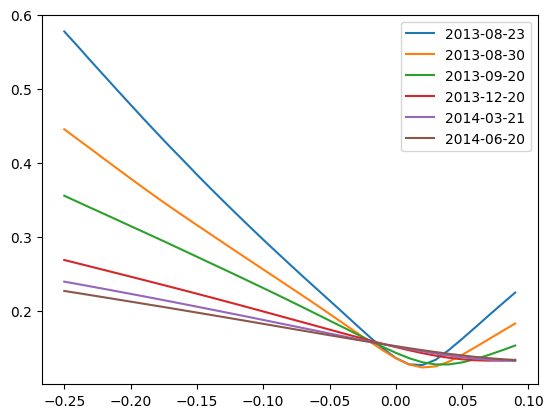

In [ ]:
atm_ivs = []
exp_yrs = []
for i, exp in enumerate(expirations):
    event_cf = cf[i]
    logK = np.arange(-0.25, 0.1, 0.01)
    K = spot * np.exp(logK)
    KC = K[..., None]  # Turn into a column vector

    prices = np.maximum(event_cf - KC, 0).mean(axis=1)

    T = (exp - prc_dt).days / 365.25
    iv_vec = [find_vol(p, spot, k, T, rate) for p, k in zip(prices, K)]
    plt.plot(logK, iv_vec, label=exp.strftime("%Y-%m-%d"))

    exp_yrs.append(T)
    atm_ivs.append(iv_vec[25])
plt.legend()

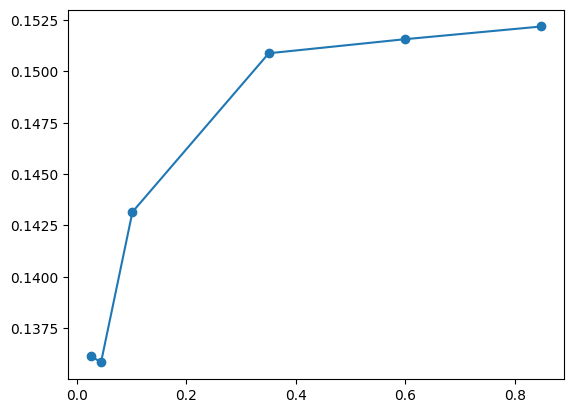

In [ ]:
plt.plot(exp_yrs, atm_ivs, label="ATM IV", marker="o")